In [1]:
!pip install salesforce-merlion

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 554.2/554.2 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.68
    Uninstalling cmdstanpy-0.9.68:
      Successfully uninstalled cmdstanpy-0.9.68
  Attempting uninstall: prophet
    Found existing installation: prophet 1.0.1
    Uninstalling prophet-1.0.1:
      Successfully uninstalled prophet-1.0.1


In [2]:
from merlion.utils import TimeSeries
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
from merlion.models.defaults import DefaultForecasterConfig, DefaultForecaster
from datetime import datetime
from merlion.evaluate.forecast import ForecastMetric
from merlion.models.factory import ModelFactory
from merlion.models.ensemble.combine import ModelSelector
from merlion.evaluate.forecast import ForecastMetric
from typing import Union
import numpy as np
import pandas as pd
from pandas.core.dtypes.common import is_datetime_or_timedelta_dtype
from sklearn.model_selection._split import _BaseKFold


class GroupedTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator

    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals, in train/test sets.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate. Test splits are treated preferentially,
    i.e. if there are not enough samples the test split is filled first.
    This splitter works on a date range, which is not necessarily aligned to the
    available data if it has missing days.

    ----------

    train_window : int, default= 38
        Maximum size for a single training set.

    test_window : int, default= 7
        Used to set the size of the test set.

    train_gap : int, default= 0
        Gap (in days) before the training set.

    test_gap : int, default=0
        Gap (in days) between the training and test set.
    """

    def __init__(self, train_window: int = 38, test_window= 7, train_gap: int = 0, test_gap: int = 0, freq: str = 'D'):
        self.train_window = train_window
        self.test_window = test_window
        self.train_gap = train_gap
        self.test_gap = test_gap
        self.n_folds_ = None
        self.freq = freq

    def split(self, X: pd.DataFrame, y, dates:Union[pd.Series, np.ndarray], *_):
        """Generate indices to split data into training and test set according to provided dates.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where `n_samples` is the number of samples
            and `n_features` is the number of features.

        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.

        dates : array-like of shape (n_samples,)
            Dates of the samples, can be passed to sklearn via the `groups` parameter.

        Yields
        ------
        train : ndarray
            The training set indices for that split.

        test : ndarray
            The testing set indices for that split.
        """
        if not is_datetime_or_timedelta_dtype(dates):
            dates = pd.to_datetime(dates)

        start_date, end_date = dates.min(), dates.max()
        date_range = pd.date_range(start_date, end_date, freq=self.freq)
        n_dates = len(date_range)

        indices = np.arange(n_dates)
        train_starts = range(0, n_dates, self.train_window + self.test_window + self.train_gap + self.test_gap)

        self.n_folds_ = len(train_starts)

        for train_start in train_starts:
            avail_days = min(n_dates - train_start,
                             self.train_window + self.test_window + self.train_gap + self.test_gap)
            test_start = max(train_start, train_start + avail_days - self.test_window - self.train_gap)
            train_dates = date_range[indices[train_start: test_start - self.test_gap]]
            test_dates = date_range[test_start: train_start + avail_days - self.train_gap]
            train_indices = np.where(np.isin(dates, train_dates))[0]
            test_indices = np.where(np.isin(dates, test_dates))[0]
            if len(test_dates) < self.test_window:
                continue
            yield list(train_indices), list(test_indices)


In [3]:
date_start = "2017-01-01"
date_end="2019-09-04"
frequency="D"

In [4]:
df = pd.read_csv('../input/filtered/train_filtered.csv')
# drop index for feature preparation
df_ = df.drop(columns='pseudo_id')
# convert dates to pandas datetime
df_.columns = [datetime.strptime(c, "%Y-%m-%d %H:%M:%S") for c in df_.columns]
# Aggregate energy use values per day/hour
if frequency == "D":
    df_ = df_.T.groupby(df_.T.index.date).sum()
else:
    df_ = df_.T.resample("H").sum()
# Set dates for development phase
new_date_range = pd.date_range(start=date_start, end=date_end, freq=frequency)
# Add test dates in the data frame
df_ = df_.reindex(new_date_range, fill_value = 0) # using dummy values in test set
# df_ = df_.T
df_.index = pd.to_datetime(df_.index)
df_.index.freq = frequency
df_.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
2017-01-01,1705.287991,147.809500,600.668506,2137.370495,1284.153008,440.589498,214.995000,1191.652002,1484.475235,510.885497,...,24.6440,319.953999,211.376749,37.7885,156.678500,19.8575,81.3585,178.964500,41.72975,114.706250
2017-01-02,1463.323000,131.234001,536.956499,1845.932997,1024.437998,367.787501,158.280999,1022.248507,1319.965008,356.898001,...,36.5830,190.435001,160.871999,42.9835,104.632999,21.0865,69.6070,140.667001,31.29550,95.185999
2017-01-03,1207.535001,105.523500,436.551002,1573.481486,769.650502,301.399500,133.719999,811.007994,1061.731504,273.863000,...,16.0125,115.016500,95.656500,35.8240,85.052500,15.3765,41.6065,109.646500,30.96700,68.452000
2017-01-04,1236.679754,95.282000,338.179750,1618.879997,742.655000,323.088001,125.280000,773.404256,1066.458754,290.986001,...,20.0665,58.392501,82.173501,31.6980,78.855501,17.3145,56.2485,119.829500,33.00200,57.583500
2017-01-05,1148.115250,78.768249,334.507498,1605.510998,686.648498,283.011000,119.048000,690.281743,1060.132254,290.217501,...,10.4050,58.395001,80.986500,31.2245,78.016500,17.9085,49.5710,119.899000,37.69800,48.995000


In [5]:
train_window = 38
train_window_size = 45 * 3
max_forecast_steps = 7
max_target_seq_index = df_.shape[1]

In [6]:
tscv = GroupedTimeSeriesSplit(train_window=train_window, test_window=max_forecast_steps, train_gap = 0, freq = frequency)
for target_seq_index in range(0, max_target_seq_index):
    
    print("Dwelling:", target_seq_index)
    
    kwargs = dict(max_forecast_steps=max_forecast_steps, target_seq_index=target_seq_index)
    model1 = ModelFactory.create("DefaultForecaster", **kwargs)
    model2 = ModelFactory.create("Arima", **kwargs)

    # This ModelSelector combiner picks the best model based on sMAPE
    model = ModelFactory.create("ForecasterEnsemble", models=[model1, model2],
                                     combiner=ModelSelector(metric=ForecastMetric.sMAPE))
    split = 0
    for train_ind, test_ind in tscv.split(df_, y=df_, dates = df_.index):
        print("** Split:", split)
        split += 1

        ### Prepare data for Training
        last_index = train_ind[-1]
        window_size = train_window_size
        window_end = last_index + 1
        window_start = max(0, window_end - window_size)
        train_ind_all = range(window_start, window_end)
        X_train_df = df_.iloc[train_ind_all].copy()
        X_train = TimeSeries.from_pd(X_train_df)

        ### Training
        train_pred, train_stderr = model.train(X_train)

        ### Prepare data for Forecasting
        X_test_df = df_.iloc[test_ind].copy()
        X_test = TimeSeries.from_pd(X_test_df)
        target_univariate = X_test.univariates[X_test.names[target_seq_index]]
        target = target_univariate.to_ts()
        
        ### Forecasting
        forecast, stderr = model.forecast(target.time_stamps)
        
        ### Save the forecast back to the dataframe
        forecast = DataFrame(forecast.to_pd())
        forecast = forecast.values.reshape(max_forecast_steps)
        df_.iloc[test_ind,target_seq_index] = forecast
        
    ### Save the model for each dwelling
    df_.to_csv('out.csv', index=False)
    
    ### Save the forecast back to the dataframe
    model.save('model_'+str(target_seq_index))

Dwelling: 0
** Split: 0


** Split: 1
** Split: 2
** Split: 3
** Split: 4
** Split: 5
** Split: 6
** Split: 7
** Split: 8
** Split: 9
** Split: 10
** Split: 11
** Split: 12
** Split: 13
** Split: 14
** Split: 15
** Split: 16
** Split: 17
** Split: 18
** Split: 19
** Split: 20
** Split: 21
Dwelling: 1
** Split: 0
** Split: 1
** Split: 2
** Split: 3
** Split: 4
** Split: 5
** Split: 6
** Split: 7
** Split: 8
** Split: 9
** Split: 10
** Split: 11
** Split: 12
** Split: 13
** Split: 14
** Split: 15
** Split: 16
** Split: 17
** Split: 18
** Split: 19
** Split: 20
** Split: 21
Dwelling: 2
** Split: 0
** Split: 1
** Split: 2
** Split: 3
** Split: 4
** Split: 5
** Split: 6
** Split: 7
** Split: 8
** Split: 9
** Split: 10
** Split: 11
** Split: 12
** Split: 13
** Split: 14
** Split: 15
** Split: 16
** Split: 17
** Split: 18
** Split: 19
** Split: 20
** Split: 21
Dwelling: 3
** Split: 0
** Split: 1
** Split: 2
** Split: 3
** Split: 4
** Split: 5
** Split: 6
** Split: 7
** Split: 8
** Split: 9
** Split: 10
** Split: 11
**

<AxesSubplot:>

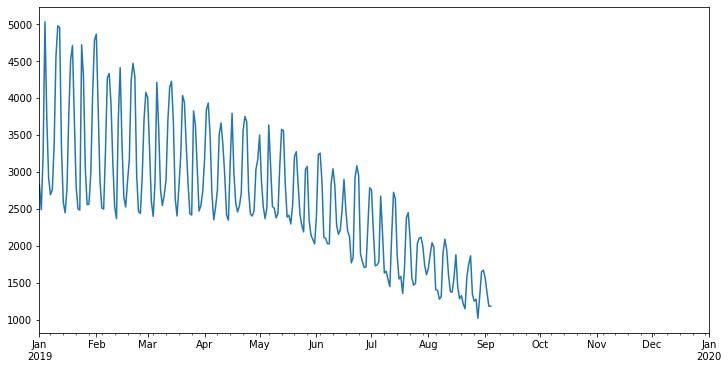

In [7]:
new_date_range = pd.date_range(start="2019-01-01", end="2020-01-01", freq="D")
df_year_17 = df_.reindex(new_date_range)
df_year_17.loc[: , 0].plot(figsize=(12,6))